# https://scib-metrics.readthedocs.io/en/latest/notebooks/lung_example.html

Random seed set as 42
/home/figo/software/python_libs/scbiot/examples
/home/figo/software/python_libs/scbiot


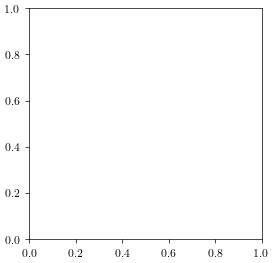

In [86]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import scanpy as sc
import seaborn as sns
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
import torch
import os
import pandas as pd
import scbiot as scb
from scbiot.utils import set_seed

import harmonypy as hm
from umap import UMAP
# %pip install scib-metrics
from scib_metrics.benchmark import Benchmarker, BioConservation, BatchCorrection

set_seed(42)

from pathlib import Path
dir = Path.cwd()
print(dir)
parent_dir = dir.parent
print(parent_dir)

from scimorph.theme_publication import theme_publication
from scimorph.utils import set_seed
theme_publication()


In [ ]:
adata_gex_path = f'{dir}/inputs/Chen-2021-RNA.h5ad'
adata_atac_path = f'{dir}/inputs/Chen-2021-ATAC.h5ad'

adata_gex = sc.read(
    adata_gex_path,
    backup_url="https://figshare.com/ndownloader/files/59742638",
)

adata_atac = sc.read(
    adata_atac_path,
    backup_url="https://figshare.com/ndownloader/files/59742644",
)

In [88]:
# --- Combine paired snRNA + snATAC into one AnnData (vars = genes ∪ peaks) ---
import anndata as ad
import numpy as np
import pandas as pd
from scipy.sparse import issparse, csr_matrix

def _to_csr32(X):
    if issparse(X):
        X = X.tocsr(copy=False)
        if X.dtype != np.float32:
            X = X.astype(np.float32)
        return X
    # dense → sparse
    X = csr_matrix(X)
    if X.dtype != np.float32:
        X = X.astype(np.float32)
    return X

# ---------------- 0) Sanity & hard alignment of cells ----------------
# Ensure identical cell sets
cells_gex  = pd.Index(adata_gex.obs_names.astype(str))
cells_atac = pd.Index(adata_atac.obs_names.astype(str))

if set(cells_gex) != set(cells_atac):
    missing_in_atac = cells_gex.difference(cells_atac)
    missing_in_gex  = cells_atac.difference(cells_gex)
    raise ValueError(
        f"Cell sets are not identical:\n"
        f"  missing_in_atac: {len(missing_in_atac)}\n"
        f"  missing_in_gex : {len(missing_in_gex)}"
    )

# Reorder ATAC to match GEX exactly (critical!)
adata_atac = adata_atac[cells_gex].copy()

# ---------------- 1) Tag modality in var['feature_types'] -------------
# NOTE: you had a small bug: use '=' not '==' for assignment.
adata_gex.var["feature_types"]  = "GEX"
adata_atac.var["feature_types"] = "ATAC"

# (Optional) a scvi-style alias if you need it later
# map_ft = {"GEX": "Gene Expression", "ATAC": "Peaks"}
# for a in (adata_gex, adata_atac):
#     a.var["feature_types_scvi"] = a.var["feature_types"].map(map_ft)

# Make feature names unique within each modality (no-op if already unique)
adata_gex.var_names_make_unique()
adata_atac.var_names_make_unique()

# ---------------- 2) Ensure a 'counts' layer and CSR float32 ----------
def ensure_counts_layer(a):
    if "counts" not in a.layers:
        a.layers["counts"] = a.X.copy()  # treat current X as counts
    # Keep X as counts too (simple & consistent for concatenation)
    a.layers["counts"] = _to_csr32(a.layers["counts"])
    a.X = a.layers["counts"]  # X=counts; you can normalize into a new layer later

ensure_counts_layer(adata_gex)
ensure_counts_layer(adata_atac)

# ---------------- 3) Concatenate along variables (genes + peaks) ------
# This keeps obs identical, stacks features, merges layers by name.
adata = ad.concat(
    [adata_gex, adata_atac],
    axis=1,                 # concatenate columns (features)
    join="outer",           # union of var columns
    label=None,             # no key added to obs
    merge="first",          # for shared .obs/.var columns, take first non-null
)

# ---------------- 4) Carry over embeddings (if present & useful) ------
# You can keep separate views in obsm for convenience
for key in ("X_pca", "X_umap", "X_tsne", "X_lsi"):
    if key in adata_gex.obsm:
        adata.obsm[f"{key}_gex"] = adata_gex.obsm[key]
    if key in adata_atac.obsm:
        adata.obsm[f"{key}_atac"] = adata_atac.obsm[key]

# ---------------- 5) Quick report ------------------------------------
n_genes = (adata.var["feature_types"] == "GEX").sum() if "feature_types" in adata.var else np.nan
n_peaks = (adata.var["feature_types"] == "ATAC").sum() if "feature_types" in adata.var else np.nan
print(adata)
print(f"features: genes={n_genes}, peaks={n_peaks}")
print("layers:", list(adata.layers.keys()))
print("example var columns:", adata.var.columns[:10].tolist())


AnnData object with n_obs × n_vars = 9190 × 270687
    obs: 'domain', 'protocol', 'dataset', 'cell_type'
    var: 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'mgi_id', 'havana_gene', 'tag', 'genome', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'feature_types'
    layers: 'counts'
features: genes=28930, peaks=241757
layers: ['counts']
example var columns: ['chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount']


In [89]:
# ---------------- 6) Batch / replicate labels from cell-id prefix -------------
import re

# Everything up to the first "_" or "-" is the batch id (e.g., "09A" from "09A_XXXX")
pat = r'^(?P<batch>[^_-]+)[_-]'

name_s = pd.Series(adata.obs_names.astype(str), index=adata.obs_names)
batch  = name_s.str.extract(pat)['batch'].fillna("UNK")

# Natural-sort categories so 9 < 10 (i.e., "09A", "09B", ..., "10A")
def _natkey(s):
    return [int(t) if t.isdigit() else t for t in re.split(r'(\d+)', str(s))]

cats = sorted(pd.unique(batch), key=_natkey)
adata.obs['batch'] = pd.Categorical(batch, categories=cats, ordered=True)

# Quick check
print("Batches:", list(adata.obs['batch'].cat.categories))
print(adata.obs['batch'].value_counts())


Batches: ['09A', '09B', '09C', '09D', '09E', '09F', '09G', '09H', '09I', '09J', '09K', '09L']
batch
09D    819
09G    809
09C    800
09F    799
09B    794
09I    781
09J    759
09K    749
09H    748
09A    721
09E    707
09L    704
Name: count, dtype: int64


In [90]:
# split to gex and peaks
gex_vars = adata.var['feature_types'] == 'GEX'
adata_gex = adata[:, gex_vars].copy()

# Filter for ATAC-related variables
atac_vars = adata.var['feature_types'] == 'ATAC'
adata_atac = adata[:, atac_vars].copy()

In [91]:
adata_gex

AnnData object with n_obs × n_vars = 9190 × 28930
    obs: 'domain', 'protocol', 'dataset', 'cell_type', 'batch'
    var: 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'mgi_id', 'havana_gene', 'tag', 'genome', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'feature_types'
    layers: 'counts'

In [92]:
sc.pp.highly_variable_genes(adata_gex, n_top_genes=2000, flavor="seurat_v3")
sc.pp.normalize_total(adata_gex)
sc.pp.log1p(adata_gex)
sc.pp.scale(adata_gex)
sc.tl.pca(adata_gex, n_comps=30, use_highly_variable=True)

# save back
adata.obsm["X_pca"] = adata_gex.obsm["X_pca"]

In [ ]:
# figshare gtf file link: https://figshare.com/ndownloader/files/59742641

adata_top = scb.pp.remove_promoter_proximal_peaks(adata_atac, gtf_file=f'{dir}/inputs/gencode.vM25.chr_patch_hapl_scaff.annotation.gtf.gz')

# Peak selection
scb.pp.find_variable_features(adata_top, topN=30000, batch_key="batch")

scb.pp.add_iterative_lsi(adata_top, n_components=31, drop_first_component=True, add_key="X_lsi")


# Save back
adata_atac.obsm["X_lsi"] = adata_top.obsm["X_lsi"]
adata.obsm["X_lsi"] = adata_top.obsm["X_lsi"]

Removed 25,110 promoter-proximal peaks (2000bp upstream / 500bp downstream). Remaining: 216,647
Running Iterative LSI iteration 1 ...
Running Iterative LSI iteration 2 ...
Running Iterative LSI iteration 3 ...
Running Iterative LSI iteration 4 ...
Running Iterative LSI iteration 5 ...


In [94]:
adata, metrics = scb.ot.integrate(
    adata,
    modality='paired',
    obsm_key="X_pca",              # base view for geometry/smoothing
    batch_key="batch",
    out_key="X_ot",
    mode="ufgw_barycenter",        
    view_keys=("X_pca", "X_lsi"),   
    K_pseudo = 24,
    
)
print(metrics)

[baseline] KNN backend=FAISS-GPU mix=2.2572 strain=0.00000 mode=ufgw_barycenter
[iter 01] mix=2.266 overlap0=0.788 strain=0.00782 J=0.014 best_it=1
[iter 02] mix=2.269 overlap0=0.560 strain=0.03476 J=-0.063 best_it=1
[iter 03] mix=2.269 overlap0=0.561 strain=0.03343 J=-0.062 best_it=1
[iter 04] mix=2.268 overlap0=0.554 strain=0.03627 J=-0.075 best_it=1
[early stop] plateau reached.
[final] it*=1 mix=2.266 overlap0=0.788 strain=0.00782 tw=0.998
{'mix': 2.26558149162531, 'overlap0': 0.7875333428382874, 'strain': 0.007824914529919624, 'tw': 0.9983444829225232, 'it': 1}


In [95]:
sc.pp.neighbors(adata, use_rep='X_ot', n_neighbors=8)
sc.tl.umap(adata, min_dist=0.10, spread=1.0)
sc.tl.leiden(adata, key_added='leiden_X_ot', resolution=1.)

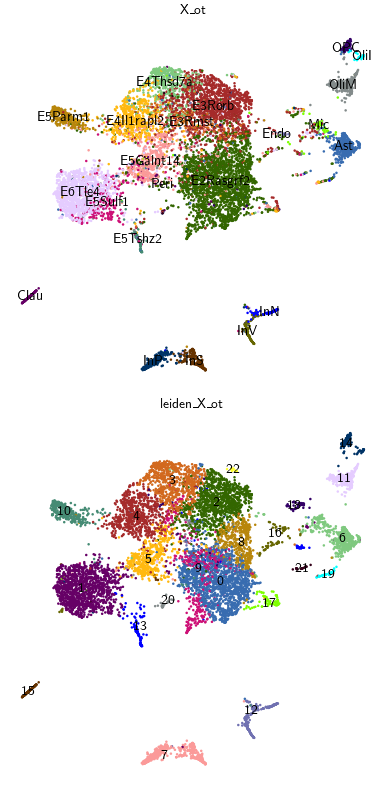

In [96]:
import matplotlib.pyplot as plt
import scanpy as sc

methods = ["X_ot"]

# 2 rows x len(methods) columns
fig, axes = plt.subplots(
    2,
    len(methods),
    figsize=(4 * len(methods), 8),
    squeeze=False  # ensures axes is a 2D array
)

for col, method in enumerate(methods):
    # 1) Top row (row=0): color by "batch"
    sc.pl.embedding(
        adata,
        basis=f"X_umap",  # The coordinates stored in adata.obsm["X_umap_{method}"]
        color="cell_type",            # Assume adata.obs["batch"] exists
        frameon=False,
        ax=axes[0, col],
        show=False,
        legend_loc="on data",
        legend_fontsize=10,  # smaller font
        title=f"{method}"
    )

    # 2) Bottom row (row=1): color by the Leiden clusters for this method
    leiden_key = f"leiden_{method}"
    sc.pl.embedding(
        adata,
        basis=f"X_umap",
        color=leiden_key,         # Column in adata.obs
        frameon=False,
        ax=axes[1, col],
        show=False,
        legend_loc="on data",
        legend_fontsize=10,  # smaller font
        # title=f"{method}"
    )

plt.tight_layout()
# fig.savefig("batch_and_leiden_per_embedding.pdf", dpi=300)
# plt.close(fig)


In [97]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

df = pd.DataFrame(adata.obsm['X_ot'], index=adata.obs.index) # adata.X.toarray()
df['batch'] = adata.obs['batch']

df['target'] = adata.obs['cell_type']
# Step 1: Get the counts of each category
category_counts = df['target'].value_counts()
# Step 2: Create a mapping of categories to numbers based on descending counts
category_mapping = {category: idx for idx, category in enumerate(category_counts.index)}
# Step 3: Map the original categorical column to the new numeric values
df['target'] = df['target'].map(category_mapping)

df['pseudo'] = adata.obs['leiden_X_ot'] #adata.obs['leiden_multiome_harmony']
# Step 1: Get the counts of each category
category_counts = df['pseudo'].value_counts()
# Step 2: Create a mapping of categories to numbers based on descending counts
category_mapping = {category: idx for idx, category in enumerate(category_counts.index)}
# Step 3: Map the original categorical column to the new numeric values
df['pseudo'] = df['pseudo'].map(category_mapping)

df.index.name = "barcode"
df = df.reset_index().set_index(['barcode', 'batch', 'target', 'pseudo'])

# Extract numeric labels
true_labels = df.reset_index()['target']
pred_labels = df.reset_index()['pseudo']

# Calculate NMI
nmi_score = normalized_mutual_info_score(true_labels, pred_labels)
ari_score = adjusted_rand_score(true_labels, pred_labels)

print("NMI:", nmi_score)
print("ARI:", ari_score)


NMI: 0.6429237392955011
ARI: 0.5349711063694629


In [98]:
scb.pp.setup_anndata(adata, var_key='X_ot', batch_key='batch', pseudo_key='leiden_X_ot', true_key=None)

{'var_key': 'X_ot',
 'batch_key': 'batch',
 'pseudo_key': 'leiden_X_ot',
 'true_key': None}

In [99]:
model = scb.models.vae(adata, verbose=True)

Random seed set as 42
[Explicit labels] has_pseudo=True
[Explicit labels] batch_train/test: torch.Size([8271]) / torch.Size([919])
[Explicit labels] pseudo_train/test: torch.Size([8271]) / torch.Size([919])


In [100]:
model.train()

Training:   1%|▏         | 1/80 [00:00<01:14,  1.06it/s, epoch=1/80, Train_loss=2.9774, Test_loss=2.8276]

Saved whole dataset latents (N=9190)
{'Train NMI': 0.208, 'Train ARI': 0.011, 'Train ACC': 0.192, 'Train kBET': 0.956, 'Train CCR': 100.0}


Training:   2%|▎         | 2/80 [00:01<00:48,  1.61it/s, epoch=2/80, Train_loss=3.8210, Test_loss=3.5915]

Saved whole dataset latents (N=9190)
{'Train NMI': 0.241, 'Train ARI': 0.01, 'Train ACC': 0.206, 'Train kBET': 0.963, 'Train CCR': 58.228}


Training:   4%|▍         | 3/80 [00:01<00:39,  1.93it/s, epoch=3/80, Train_loss=4.4910, Test_loss=4.2308]

Saved whole dataset latents (N=9190)
{'Train NMI': 0.276, 'Train ARI': 0.017, 'Train ACC': 0.221, 'Train kBET': 0.968, 'Train CCR': 49.367}


Training:   5%|▌         | 4/80 [00:02<00:33,  2.28it/s, epoch=4/80, Train_loss=4.9986, Test_loss=4.6682]

{'Train NMI': 0.246, 'Train ARI': 0.016, 'Train ACC': 0.226, 'Train kBET': 0.955, 'Train CCR': 69.62}


Training:   6%|▋         | 5/80 [00:02<00:31,  2.38it/s, epoch=5/80, Train_loss=5.3060, Test_loss=4.9555]

Saved whole dataset latents (N=9190)
{'Train NMI': 0.302, 'Train ARI': 0.047, 'Train ACC': 0.26, 'Train kBET': 0.957, 'Train CCR': 75.949}


Training:   8%|▊         | 6/80 [00:02<00:30,  2.44it/s, epoch=6/80, Train_loss=5.5755, Test_loss=5.1286]

Saved whole dataset latents (N=9190)
{'Train NMI': 0.37, 'Train ARI': 0.079, 'Train ACC': 0.301, 'Train kBET': 0.929, 'Train CCR': 39.241}


Training:   9%|▉         | 7/80 [00:03<00:29,  2.48it/s, epoch=7/80, Train_loss=5.0225, Test_loss=4.7651]

Saved whole dataset latents (N=9190)
{'Train NMI': 0.389, 'Train ARI': 0.11, 'Train ACC': 0.339, 'Train kBET': 0.936, 'Train CCR': 68.354}


Training:  10%|█         | 8/80 [00:04<00:42,  1.69it/s, epoch=8/80, Train_loss=4.8244, Test_loss=4.5567]

Saved whole dataset latents (N=9190)
{'Train NMI': 0.428, 'Train ARI': 0.168, 'Train ACC': 0.356, 'Train kBET': 0.918, 'Train CCR': 84.81}


Training:  11%|█▏        | 9/80 [00:04<00:37,  1.90it/s, epoch=9/80, Train_loss=4.4818, Test_loss=4.4177]

Saved whole dataset latents (N=9190)
{'Train NMI': 0.438, 'Train ARI': 0.159, 'Train ACC': 0.337, 'Train kBET': 0.866, 'Train CCR': 88.608}


Training:  12%|█▎        | 10/80 [00:04<00:33,  2.11it/s, epoch=10/80, Train_loss=4.2407, Test_loss=4.2686]

Saved whole dataset latents (N=9190)
{'Train NMI': 0.444, 'Train ARI': 0.155, 'Train ACC': 0.364, 'Train kBET': 0.803, 'Train CCR': 97.468}


Training:  14%|█▍        | 11/80 [00:05<00:30,  2.26it/s, epoch=11/80, Train_loss=4.1732, Test_loss=4.1718]

Saved whole dataset latents (N=9190)
{'Train NMI': 0.468, 'Train ARI': 0.189, 'Train ACC': 0.398, 'Train kBET': 0.797, 'Train CCR': 100.0}


Training:  15%|█▌        | 12/80 [00:05<00:28,  2.36it/s, epoch=12/80, Train_loss=4.1554, Test_loss=4.0893]

Saved whole dataset latents (N=9190)
{'Train NMI': 0.509, 'Train ARI': 0.21, 'Train ACC': 0.425, 'Train kBET': 0.765, 'Train CCR': 98.734}


Training:  16%|█▋        | 13/80 [00:06<00:25,  2.59it/s, epoch=13/80, Train_loss=4.0234, Test_loss=4.0048]

{'Train NMI': 0.467, 'Train ARI': 0.159, 'Train ACC': 0.365, 'Train kBET': 0.768, 'Train CCR': 96.203}


Training:  18%|█▊        | 14/80 [00:06<00:24,  2.75it/s, epoch=14/80, Train_loss=4.1574, Test_loss=3.9962]

{'Train NMI': 0.499, 'Train ARI': 0.208, 'Train ACC': 0.424, 'Train kBET': 0.766, 'Train CCR': 94.937}


Training:  19%|█▉        | 15/80 [00:06<00:22,  2.87it/s, epoch=15/80, Train_loss=4.0853, Test_loss=4.2009]

{'Train NMI': 0.499, 'Train ARI': 0.192, 'Train ACC': 0.42, 'Train kBET': 0.736, 'Train CCR': 93.671}


Training:  20%|██        | 16/80 [00:07<00:31,  2.05it/s, epoch=16/80, Train_loss=4.0682, Test_loss=4.0935]

{'Train NMI': 0.495, 'Train ARI': 0.199, 'Train ACC': 0.394, 'Train kBET': 0.75, 'Train CCR': 91.139}


Training:  21%|██▏       | 17/80 [00:07<00:27,  2.31it/s, epoch=17/80, Train_loss=4.1062, Test_loss=3.9775]

{'Train NMI': 0.49, 'Train ARI': 0.195, 'Train ACC': 0.381, 'Train kBET': 0.714, 'Train CCR': 94.937}


Training:  22%|██▎       | 18/80 [00:08<00:25,  2.39it/s, epoch=18/80, Train_loss=3.9288, Test_loss=3.8624]

Saved whole dataset latents (N=9190)
{'Train NMI': 0.515, 'Train ARI': 0.21, 'Train ACC': 0.42, 'Train kBET': 0.746, 'Train CCR': 98.734}


Training:  24%|██▍       | 19/80 [00:08<00:24,  2.46it/s, epoch=19/80, Train_loss=3.8399, Test_loss=3.7807]

Saved whole dataset latents (N=9190)
{'Train NMI': 0.528, 'Train ARI': 0.256, 'Train ACC': 0.44, 'Train kBET': 0.739, 'Train CCR': 100.0}


Training:  25%|██▌       | 20/80 [00:08<00:22,  2.65it/s, epoch=20/80, Train_loss=3.7183, Test_loss=3.6916]

{'Train NMI': 0.512, 'Train ARI': 0.231, 'Train ACC': 0.427, 'Train kBET': 0.743, 'Train CCR': 94.937}


Training:  26%|██▋       | 21/80 [00:09<00:21,  2.79it/s, epoch=21/80, Train_loss=3.6328, Test_loss=3.6018]

{'Train NMI': 0.5, 'Train ARI': 0.223, 'Train ACC': 0.418, 'Train kBET': 0.736, 'Train CCR': 96.203}


Training:  28%|██▊       | 22/80 [00:09<00:19,  2.93it/s, epoch=22/80, Train_loss=3.5524, Test_loss=3.4960]

{'Train NMI': 0.516, 'Train ARI': 0.218, 'Train ACC': 0.423, 'Train kBET': 0.738, 'Train CCR': 97.468}


Training:  29%|██▉       | 23/80 [00:10<00:28,  1.99it/s, epoch=23/80, Train_loss=3.5349, Test_loss=3.4176]

Saved whole dataset latents (N=9190)
{'Train NMI': 0.539, 'Train ARI': 0.22, 'Train ACC': 0.446, 'Train kBET': 0.743, 'Train CCR': 98.734}


Training:  30%|███       | 24/80 [00:10<00:26,  2.15it/s, epoch=24/80, Train_loss=3.5572, Test_loss=3.3252]

Saved whole dataset latents (N=9190)
{'Train NMI': 0.558, 'Train ARI': 0.259, 'Train ACC': 0.463, 'Train kBET': 0.736, 'Train CCR': 91.139}


Training:  31%|███▏      | 25/80 [00:11<00:24,  2.27it/s, epoch=25/80, Train_loss=3.1891, Test_loss=3.2671]

Saved whole dataset latents (N=9190)
{'Train NMI': 0.614, 'Train ARI': 0.375, 'Train ACC': 0.518, 'Train kBET': 0.746, 'Train CCR': 94.937}


Training:  32%|███▎      | 26/80 [00:11<00:21,  2.47it/s, epoch=26/80, Train_loss=3.2100, Test_loss=3.1833]

{'Train NMI': 0.581, 'Train ARI': 0.302, 'Train ACC': 0.478, 'Train kBET': 0.747, 'Train CCR': 100.0}


Training:  34%|███▍      | 27/80 [00:11<00:20,  2.62it/s, epoch=27/80, Train_loss=3.1553, Test_loss=3.1286]

{'Train NMI': 0.573, 'Train ARI': 0.295, 'Train ACC': 0.475, 'Train kBET': 0.731, 'Train CCR': 96.203}


Training:  35%|███▌      | 28/80 [00:12<00:18,  2.75it/s, epoch=28/80, Train_loss=3.1565, Test_loss=3.0704]

{'Train NMI': 0.575, 'Train ARI': 0.33, 'Train ACC': 0.476, 'Train kBET': 0.741, 'Train CCR': 98.734}


Training:  36%|███▋      | 29/80 [00:12<00:17,  2.85it/s, epoch=29/80, Train_loss=2.9689, Test_loss=3.0041]

{'Train NMI': 0.606, 'Train ARI': 0.295, 'Train ACC': 0.495, 'Train kBET': 0.742, 'Train CCR': 97.468}


Training:  38%|███▊      | 30/80 [00:12<00:16,  2.96it/s, epoch=30/80, Train_loss=2.9928, Test_loss=2.9338]

{'Train NMI': 0.555, 'Train ARI': 0.334, 'Train ACC': 0.489, 'Train kBET': 0.735, 'Train CCR': 98.734}


Training:  39%|███▉      | 31/80 [00:13<00:23,  2.09it/s, epoch=31/80, Train_loss=2.8818, Test_loss=2.8896]

{'Train NMI': 0.579, 'Train ARI': 0.306, 'Train ACC': 0.483, 'Train kBET': 0.761, 'Train CCR': 97.468}


Training:  40%|████      | 32/80 [00:13<00:20,  2.35it/s, epoch=32/80, Train_loss=2.8248, Test_loss=2.8326]

{'Train NMI': 0.599, 'Train ARI': 0.348, 'Train ACC': 0.535, 'Train kBET': 0.763, 'Train CCR': 97.468}


Training:  41%|████▏     | 33/80 [00:14<00:18,  2.57it/s, epoch=33/80, Train_loss=2.8229, Test_loss=2.7755]

{'Train NMI': 0.589, 'Train ARI': 0.326, 'Train ACC': 0.47, 'Train kBET': 0.741, 'Train CCR': 100.0}


Training:  42%|████▎     | 34/80 [00:14<00:17,  2.58it/s, epoch=34/80, Train_loss=2.8428, Test_loss=2.7272]

Saved whole dataset latents (N=9190)
{'Train NMI': 0.659, 'Train ARI': 0.37, 'Train ACC': 0.533, 'Train kBET': 0.753, 'Train CCR': 94.937}


Training:  44%|████▍     | 35/80 [00:14<00:16,  2.76it/s, epoch=35/80, Train_loss=2.6968, Test_loss=2.7119]

{'Train NMI': 0.64, 'Train ARI': 0.387, 'Train ACC': 0.542, 'Train kBET': 0.747, 'Train CCR': 97.468}


Training:  45%|████▌     | 36/80 [00:15<00:15,  2.88it/s, epoch=36/80, Train_loss=2.6356, Test_loss=2.7091]

{'Train NMI': 0.615, 'Train ARI': 0.324, 'Train ACC': 0.479, 'Train kBET': 0.752, 'Train CCR': 96.203}


Training:  46%|████▋     | 37/80 [00:15<00:14,  2.94it/s, epoch=37/80, Train_loss=2.7160, Test_loss=2.6705]

{'Train NMI': 0.604, 'Train ARI': 0.357, 'Train ACC': 0.496, 'Train kBET': 0.718, 'Train CCR': 97.468}


Training:  48%|████▊     | 38/80 [00:15<00:13,  3.02it/s, epoch=38/80, Train_loss=2.5662, Test_loss=2.6613]

{'Train NMI': 0.631, 'Train ARI': 0.357, 'Train ACC': 0.488, 'Train kBET': 0.757, 'Train CCR': 93.671}


Training:  49%|████▉     | 39/80 [00:16<00:20,  2.03it/s, epoch=39/80, Train_loss=2.5929, Test_loss=2.6528]

Saved whole dataset latents (N=9190)
{'Train NMI': 0.664, 'Train ARI': 0.416, 'Train ACC': 0.571, 'Train kBET': 0.726, 'Train CCR': 97.468}


Training:  50%|█████     | 40/80 [00:16<00:17,  2.28it/s, epoch=40/80, Train_loss=2.5981, Test_loss=2.6253]

{'Train NMI': 0.644, 'Train ARI': 0.415, 'Train ACC': 0.541, 'Train kBET': 0.746, 'Train CCR': 98.734}


Training:  51%|█████▏    | 41/80 [00:17<00:15,  2.51it/s, epoch=41/80, Train_loss=2.6360, Test_loss=2.5854]

{'Train NMI': 0.653, 'Train ARI': 0.439, 'Train ACC': 0.549, 'Train kBET': 0.744, 'Train CCR': 93.671}


Training:  52%|█████▎    | 42/80 [00:17<00:14,  2.64it/s, epoch=42/80, Train_loss=2.4807, Test_loss=2.5677]

{'Train NMI': 0.651, 'Train ARI': 0.37, 'Train ACC': 0.525, 'Train kBET': 0.726, 'Train CCR': 97.468}


Training:  54%|█████▍    | 43/80 [00:17<00:13,  2.79it/s, epoch=43/80, Train_loss=2.5909, Test_loss=2.5554]

{'Train NMI': 0.627, 'Train ARI': 0.378, 'Train ACC': 0.49, 'Train kBET': 0.75, 'Train CCR': 98.734}


Training:  55%|█████▌    | 44/80 [00:18<00:12,  2.88it/s, epoch=44/80, Train_loss=2.5363, Test_loss=2.5406]

{'Train NMI': 0.663, 'Train ARI': 0.405, 'Train ACC': 0.513, 'Train kBET': 0.737, 'Train CCR': 96.203}


Training:  56%|█████▋    | 45/80 [00:18<00:11,  2.95it/s, epoch=45/80, Train_loss=2.6354, Test_loss=2.5647]

{'Train NMI': 0.626, 'Train ARI': 0.329, 'Train ACC': 0.48, 'Train kBET': 0.762, 'Train CCR': 96.203}


Training:  57%|█████▊    | 46/80 [00:18<00:11,  3.01it/s, epoch=46/80, Train_loss=2.5958, Test_loss=2.5994]

{'Train NMI': 0.647, 'Train ARI': 0.405, 'Train ACC': 0.527, 'Train kBET': 0.734, 'Train CCR': 97.468}


Training:  59%|█████▉    | 47/80 [00:19<00:15,  2.12it/s, epoch=47/80, Train_loss=2.5801, Test_loss=2.5685]

{'Train NMI': 0.643, 'Train ARI': 0.351, 'Train ACC': 0.491, 'Train kBET': 0.752, 'Train CCR': 94.937}


Training:  60%|██████    | 48/80 [00:19<00:13,  2.36it/s, epoch=48/80, Train_loss=2.7079, Test_loss=2.5338]

{'Train NMI': 0.627, 'Train ARI': 0.365, 'Train ACC': 0.513, 'Train kBET': 0.735, 'Train CCR': 100.0}


Training:  61%|██████▏   | 49/80 [00:20<00:12,  2.57it/s, epoch=49/80, Train_loss=2.5449, Test_loss=2.5528]

{'Train NMI': 0.658, 'Train ARI': 0.382, 'Train ACC': 0.533, 'Train kBET': 0.745, 'Train CCR': 98.734}


Training:  62%|██████▎   | 50/80 [00:20<00:11,  2.59it/s, epoch=50/80, Train_loss=2.4640, Test_loss=2.5487]

Saved whole dataset latents (N=9190)
{'Train NMI': 0.668, 'Train ARI': 0.438, 'Train ACC': 0.568, 'Train kBET': 0.755, 'Train CCR': 98.734}


Training:  64%|██████▍   | 51/80 [00:20<00:10,  2.74it/s, epoch=51/80, Train_loss=2.5919, Test_loss=2.5423]

{'Train NMI': 0.598, 'Train ARI': 0.306, 'Train ACC': 0.486, 'Train kBET': 0.728, 'Train CCR': 97.468}


Training:  65%|██████▌   | 52/80 [00:21<00:09,  2.86it/s, epoch=52/80, Train_loss=2.5649, Test_loss=2.5197]

{'Train NMI': 0.634, 'Train ARI': 0.414, 'Train ACC': 0.534, 'Train kBET': 0.756, 'Train CCR': 100.0}


Training:  66%|██████▋   | 53/80 [00:21<00:09,  2.96it/s, epoch=53/80, Train_loss=2.4910, Test_loss=2.5169]

{'Train NMI': 0.652, 'Train ARI': 0.431, 'Train ACC': 0.552, 'Train kBET': 0.721, 'Train CCR': 100.0}


Training:  68%|██████▊   | 54/80 [00:21<00:09,  2.87it/s, epoch=54/80, Train_loss=2.4301, Test_loss=2.5193]

Saved whole dataset latents (N=9190)
{'Train NMI': 0.671, 'Train ARI': 0.391, 'Train ACC': 0.52, 'Train kBET': 0.763, 'Train CCR': 98.734}


Training:  69%|██████▉   | 55/80 [00:22<00:12,  1.99it/s, epoch=55/80, Train_loss=2.3859, Test_loss=2.5063]

Saved whole dataset latents (N=9190)
{'Train NMI': 0.672, 'Train ARI': 0.402, 'Train ACC': 0.514, 'Train kBET': 0.75, 'Train CCR': 97.468}


Training:  70%|███████   | 56/80 [00:23<00:10,  2.23it/s, epoch=56/80, Train_loss=2.5426, Test_loss=2.5281]

{'Train NMI': 0.658, 'Train ARI': 0.415, 'Train ACC': 0.541, 'Train kBET': 0.753, 'Train CCR': 97.468}


Training:  71%|███████▏  | 57/80 [00:23<00:09,  2.42it/s, epoch=57/80, Train_loss=2.4857, Test_loss=2.5210]

{'Train NMI': 0.635, 'Train ARI': 0.405, 'Train ACC': 0.549, 'Train kBET': 0.74, 'Train CCR': 98.734}


Training:  72%|███████▎  | 58/80 [00:23<00:08,  2.62it/s, epoch=58/80, Train_loss=2.5006, Test_loss=2.5212]

{'Train NMI': 0.657, 'Train ARI': 0.418, 'Train ACC': 0.523, 'Train kBET': 0.713, 'Train CCR': 100.0}


Training:  74%|███████▍  | 59/80 [00:24<00:07,  2.79it/s, epoch=59/80, Train_loss=2.6071, Test_loss=2.4953]

{'Train NMI': 0.587, 'Train ARI': 0.275, 'Train ACC': 0.468, 'Train kBET': 0.753, 'Train CCR': 100.0}


Training:  75%|███████▌  | 60/80 [00:24<00:07,  2.72it/s, epoch=60/80, Train_loss=2.4512, Test_loss=2.4592]

Saved whole dataset latents (N=9190)
{'Train NMI': 0.68, 'Train ARI': 0.452, 'Train ACC': 0.559, 'Train kBET': 0.711, 'Train CCR': 98.734}


Training:  76%|███████▋  | 61/80 [00:24<00:06,  2.86it/s, epoch=61/80, Train_loss=2.4785, Test_loss=2.4612]

{'Train NMI': 0.67, 'Train ARI': 0.378, 'Train ACC': 0.536, 'Train kBET': 0.726, 'Train CCR': 97.468}


Training:  78%|███████▊  | 62/80 [00:25<00:06,  2.96it/s, epoch=62/80, Train_loss=2.3820, Test_loss=2.4644]

{'Train NMI': 0.675, 'Train ARI': 0.487, 'Train ACC': 0.59, 'Train kBET': 0.737, 'Train CCR': 100.0}


Training:  79%|███████▉  | 63/80 [00:25<00:08,  2.08it/s, epoch=63/80, Train_loss=2.5077, Test_loss=2.4435]

{'Train NMI': 0.635, 'Train ARI': 0.338, 'Train ACC': 0.49, 'Train kBET': 0.708, 'Train CCR': 97.468}


Training:  80%|████████  | 64/80 [00:26<00:06,  2.33it/s, epoch=64/80, Train_loss=2.4510, Test_loss=2.4715]

{'Train NMI': 0.657, 'Train ARI': 0.453, 'Train ACC': 0.579, 'Train kBET': 0.737, 'Train CCR': 98.734}


Training:  81%|████████▏ | 65/80 [00:26<00:05,  2.53it/s, epoch=65/80, Train_loss=2.5120, Test_loss=2.4589]

{'Train NMI': 0.64, 'Train ARI': 0.414, 'Train ACC': 0.571, 'Train kBET': 0.758, 'Train CCR': 98.734}


Training:  82%|████████▎ | 66/80 [00:26<00:05,  2.73it/s, epoch=66/80, Train_loss=2.6259, Test_loss=2.4604]

{'Train NMI': 0.606, 'Train ARI': 0.364, 'Train ACC': 0.531, 'Train kBET': 0.741, 'Train CCR': 98.734}


Training:  84%|████████▍ | 67/80 [00:27<00:04,  2.89it/s, epoch=67/80, Train_loss=2.4811, Test_loss=2.4598]

{'Train NMI': 0.643, 'Train ARI': 0.405, 'Train ACC': 0.54, 'Train kBET': 0.718, 'Train CCR': 98.734}


Training:  85%|████████▌ | 68/80 [00:27<00:04,  2.76it/s, epoch=68/80, Train_loss=2.3900, Test_loss=2.4484]

Saved whole dataset latents (N=9190)
{'Train NMI': 0.683, 'Train ARI': 0.448, 'Train ACC': 0.564, 'Train kBET': 0.752, 'Train CCR': 98.734}


Training:  86%|████████▋ | 69/80 [00:27<00:03,  2.81it/s, epoch=69/80, Train_loss=2.4570, Test_loss=2.4354]

{'Train NMI': 0.614, 'Train ARI': 0.302, 'Train ACC': 0.46, 'Train kBET': 0.745, 'Train CCR': 96.203}


Training:  88%|████████▊ | 70/80 [00:28<00:04,  2.05it/s, epoch=70/80, Train_loss=2.4680, Test_loss=2.4372]

{'Train NMI': 0.654, 'Train ARI': 0.42, 'Train ACC': 0.57, 'Train kBET': 0.744, 'Train CCR': 100.0}


Training:  89%|████████▉ | 71/80 [00:29<00:04,  2.20it/s, epoch=71/80, Train_loss=2.4389, Test_loss=2.4432]

Saved whole dataset latents (N=9190)
{'Train NMI': 0.689, 'Train ARI': 0.463, 'Train ACC': 0.606, 'Train kBET': 0.751, 'Train CCR': 100.0}


Training:  90%|█████████ | 72/80 [00:29<00:03,  2.44it/s, epoch=72/80, Train_loss=2.3744, Test_loss=2.4416]

{'Train NMI': 0.652, 'Train ARI': 0.445, 'Train ACC': 0.579, 'Train kBET': 0.742, 'Train CCR': 100.0}


Training:  91%|█████████▏| 73/80 [00:29<00:02,  2.62it/s, epoch=73/80, Train_loss=2.5182, Test_loss=2.4235]

{'Train NMI': 0.633, 'Train ARI': 0.368, 'Train ACC': 0.53, 'Train kBET': 0.761, 'Train CCR': 98.734}


Training:  92%|█████████▎| 74/80 [00:29<00:02,  2.78it/s, epoch=74/80, Train_loss=2.4984, Test_loss=2.4207]

{'Train NMI': 0.662, 'Train ARI': 0.463, 'Train ACC': 0.593, 'Train kBET': 0.76, 'Train CCR': 100.0}


Training:  94%|█████████▍| 75/80 [00:30<00:01,  2.90it/s, epoch=75/80, Train_loss=2.3989, Test_loss=2.4325]

{'Train NMI': 0.64, 'Train ARI': 0.394, 'Train ACC': 0.523, 'Train kBET': 0.753, 'Train CCR': 100.0}


Training:  95%|█████████▌| 76/80 [00:30<00:01,  3.02it/s, epoch=76/80, Train_loss=2.3894, Test_loss=2.4319]

{'Train NMI': 0.648, 'Train ARI': 0.426, 'Train ACC': 0.521, 'Train kBET': 0.73, 'Train CCR': 100.0}


Training:  96%|█████████▋| 77/80 [00:30<00:00,  3.10it/s, epoch=77/80, Train_loss=2.5095, Test_loss=2.4329]

{'Train NMI': 0.622, 'Train ARI': 0.327, 'Train ACC': 0.485, 'Train kBET': 0.707, 'Train CCR': 100.0}


Training:  98%|█████████▊| 78/80 [00:31<00:00,  2.16it/s, epoch=78/80, Train_loss=2.4107, Test_loss=2.4348]

{'Train NMI': 0.661, 'Train ARI': 0.388, 'Train ACC': 0.552, 'Train kBET': 0.732, 'Train CCR': 100.0}


Training:  99%|█████████▉| 79/80 [00:32<00:00,  2.28it/s, epoch=79/80, Train_loss=2.3691, Test_loss=2.4300]

Saved whole dataset latents (N=9190)
{'Train NMI': 0.691, 'Train ARI': 0.487, 'Train ACC': 0.602, 'Train kBET': 0.713, 'Train CCR': 100.0}


Training: 100%|██████████| 80/80 [00:32<00:00,  2.49it/s, epoch=80/80, Train_loss=2.4349, Test_loss=2.4293]

{'Train NMI': 0.638, 'Train ARI': 0.455, 'Train ACC': 0.555, 'Train kBET': 0.68, 'Train CCR': 98.734}


Training: 81it [00:32,  2.48it/s, epoch=81/80, Train_loss=2.4236, Test_loss=2.4302]                        

{'Train NMI': 0.645, 'Train ARI': 0.452, 'Train ACC': 0.567, 'Train kBET': 0.735, 'Train CCR': 100.0}
Training time: 0.55 mins


In [101]:
SCBIOT_LATENT_KEY = "scBIOT"
adata.obsm[SCBIOT_LATENT_KEY] = model.get_latent_representation(n_compoents=30, svd_solver='arpack', random_state=42)

In [102]:
methods = ["X_ot", "scBIOT"] # , "scBIOT_OT"
leiden_methods = [f'{method}_leiden' for method in methods]

for method, leiden_method in zip(methods, leiden_methods):
    sc.pp.neighbors(adata, use_rep=method)
    sc.tl.umap(adata)
    adata.obsm[f"X_umap_{method}"] = adata.obsm["X_umap"].copy()
    sc.tl.leiden(adata, key_added=leiden_method, resolution=0.8)

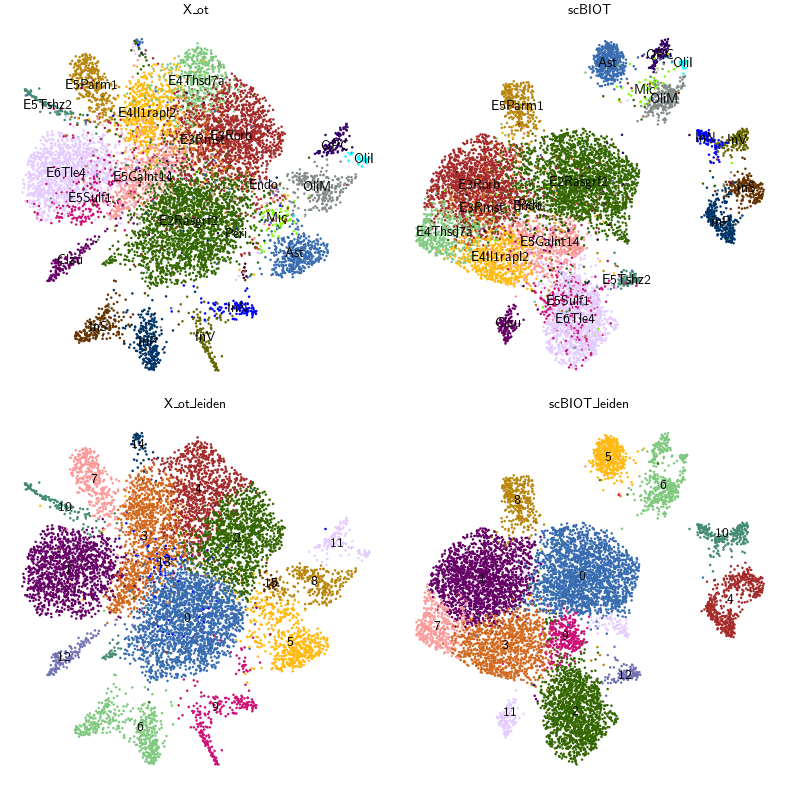

In [103]:
import matplotlib.pyplot as plt
import scanpy as sc


# 2 rows x len(methods) columns
fig, axes = plt.subplots(
    2,
    len(methods),
    figsize=(4 * len(methods), 8),
    squeeze=False  # ensures axes is a 2D array
)

for col, method in enumerate(methods):
    # 1) Top row (row=0): color by "batch"
    sc.pl.embedding(
        adata,
        basis=f"X_umap_{method}",  # The coordinates stored in adata.obsm["X_umap_{method}"]
        color="cell_type",            # Assume adata.obs["batch"] exists
        frameon=False,
        ax=axes[0, col],
        show=False,
        legend_loc="on data",
        legend_fontsize=10,  # smaller font
        title=f"{method}"
    )

    # 2) Bottom row (row=1): color by the Leiden clusters for this method
    leiden_key = f"{method}_leiden"
    sc.pl.embedding(
        adata,
        basis=f"X_umap_{method}",
        color=leiden_key,         # Column in adata.obs
        frameon=False,
        ax=axes[1, col],
        show=False,
        legend_loc="on data",
        legend_fontsize=10,  # smaller font
        # title=f"{method}"
    )

plt.tight_layout()
# fig.savefig("batch_and_leiden_per_embedding.pdf", dpi=300)
# plt.close(fig)


Embeddings: 100%|██████████| 3/3 [00:11<00:00,  3.71s/it]


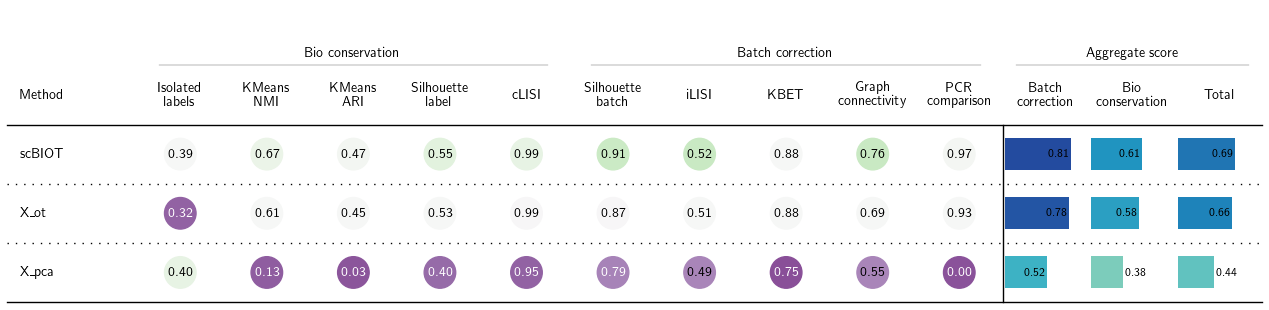

In [104]:
bm = Benchmarker(
    adata, 
    batch_key="batch",
    label_key="cell_type",
    bio_conservation_metrics=BioConservation(),
    batch_correction_metrics=BatchCorrection(),    
    embedding_obsm_keys=["X_pca", "X_ot","scBIOT"], 
    n_jobs=32
    
)
bm.benchmark()
bm.plot_results_table(min_max_scale=False)